# Code to create train and validation data splits

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from Bio import SeqIO

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from Bio.Cluster import kcluster, pca
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
tile_data = pd.read_csv("Gcn4Array_Design.csv", index_col=0)
tile_data

,ADseq,Name,ArrayDNA
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_1,ATGGCTTTGAGAATTGAAGTTTATAATAGAATTGAATCTTCTACTG...
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_6,GAAGTTTATAATAGAATTGAATCTTCTACTGCTTCTACTGCTTTGC...
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_11,ATTGAATCTTCTACTGCTTCTACTGCTTTGCAAAGACAAGATTTGA...
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_16,GCTTCTACTGCTTTGCAAAGACAAGATTTGAGATATACATTTAGAT...
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_21,CAAAGACAAGATTTGAGATATACATTTAGATCTAATGCTAGAGCTG...
...,...,...,...
47,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,Gnc4Lib_Kappa_HIGH_0,GCTAAAGTTGATACTGAAGAAGAAGATAAGACTATGGTTGATTCTA...
48,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,Gnc4Lib_Disorder_HIGH_0,TCTACTGATTATACTCCAATGTTTGAATATGAAACTTATGAAGATA...
49,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,Gnc4Lib_Disorder_HIGH_0,ATGACTGATTCTACTCCAATGTTTGAATATGAATTGACTGAGAATA...
50,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,Gnc4Lib_Charge_HIGH_0,TCTACTGATTCTACTCCAATGTTTGAATATCAGAATTTGGAGAATA...


In [3]:
input_file = "Unique_502_Gcn4_Seqs.fasta"
unqiue_seqs = SeqIO.parse(open(input_file), 'fasta')
ids = []
seqs = []
for seq in unqiue_seqs:
    ids.append(seq.id)
    seqs.append(str(seq.seq))


In [4]:
unique_gcn4 = pd.DataFrame([ids,seqs]).T
unique_gcn4.columns = ["Name", "Sequence"]

In [5]:
# This is a file calculating the distance between all pairs of full length sequences
file_name = "Unique_502_Gcn4_Seqs.fasta.hat2"

# Read in the data
with open(file_name, "r") as f:
    data = f.readlines()

# Second line is number of seqs
num_seqs = int(data[1].strip())

# Initalize an empty distance matrix
dist_mtx = np.zeros((num_seqs, num_seqs))


i = 3 + num_seqs # Skip the header rows --> There are three header lines and then a line with the name of each sequence
j = 1 # Counting the columns

while j < (num_seqs):
    row = []

    # Distances for a single row in the distance matrix span multiple rows in the hat2 file
    # This reads through a single row in the distance matrix
    # hat2 file only contains half distance matrix (because it is symetrical)
    while len(row) < (num_seqs-j):
        # Each ith row gives list of numbers, transform them to flaots
        row += [float(d) for d in data[i].strip().split()] 
        i += 1

    # Add row to distance matrix
    dist_mtx[j-1, j:j+len(row)] = row
    j += 1

# Fills in opposite half of distance matrix
dist_mtx = dist_mtx + dist_mtx.T

In [6]:
# Cluster the sequences based on the distance matrix
kcluster_result = kcluster(dist_mtx)[0]
heirarchical_clustering = linkage(dist_mtx, method='single')
heirarchical_result = fcluster(heirarchical_clustering, 3, criterion="maxclust") # End is the level, closer to end means less clusters

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_98467/1712118893.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  heirarchical_clustering = linkage(dist_mtx, method='single')


In [7]:
K = 3
Z = heirarchical_clustering
# height halfway between the merges that go from K to K-1 clusters
cut = (Z[-K, 2] + Z[-K+1, 2]) / 2.0

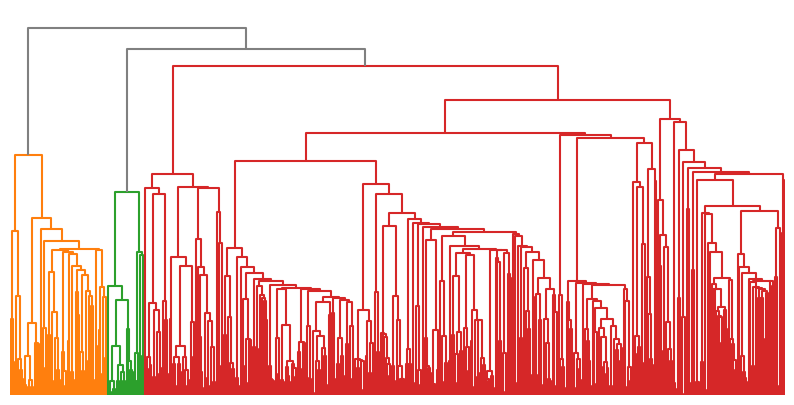

<Figure size 640x480 with 0 Axes>

In [10]:
# Plots dendogram of the clustering result

plt.figure(figsize=(10, 5))  # Set the figure size for better visibility
dn = dendrogram(
    heirarchical_clustering,
    color_threshold= cut,  # Adjust this value as needed
    above_threshold_color='gray'  # Color for merges above the threshold
)

axs = plt.gca()
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)

plt.xticks([])
plt.yticks([])
plt.show()

plt.savefig("../figures/clustering_dendogram.pdf", format='pdf', bbox_inches='tight')

In [11]:
unique_gcn4["kcluster"] = kcluster_result
unique_gcn4["heirarchical"] = heirarchical_result
unique_gcn4["heirarchical"].value_counts()

heirarchical
3    415
1     63
2     24
Name: count, dtype: int64

In [12]:
# Saving cluster results to csv
unique_gcn4.to_csv("Unique_502_Gcn4_Seqs_three_clusters.csv")

In [35]:
training_set = unique_gcn4[unique_gcn4["heirarchical"] == 3]
validation_set = unique_gcn4[unique_gcn4["heirarchical"] == 2]
test_set = unique_gcn4[unique_gcn4["heirarchical"] == 1]

In [36]:
# Getting the species each tile comes from
tile_data["Species"] = [re.sub(r'_[0-9]*$' ,"",i) for i in tile_data["Name"]]
tile_data

,ADseq,Name,ArrayDNA,Species
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_1,ATGGCTTTGAGAATTGAAGTTTATAATAGAATTGAATCTTCTACTG...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_6,GAAGTTTATAATAGAATTGAATCTTCTACTGCTTCTACTGCTTTGC...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_11,ATTGAATCTTCTACTGCTTCTACTGCTTTGCAAAGACAAGATTTGA...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_16,GCTTCTACTGCTTTGCAAAGACAAGATTTGAGATATACATTTAGAT...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_21,CAAAGACAAGATTTGAGATATACATTTAGATCTAATGCTAGAGCTG...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
...,...,...,...,...
47,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,Gnc4Lib_Kappa_HIGH_0,GCTAAAGTTGATACTGAAGAAGAAGATAAGACTATGGTTGATTCTA...,Gnc4Lib_Kappa_HIGH
48,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,Gnc4Lib_Disorder_HIGH_0,TCTACTGATTATACTCCAATGTTTGAATATGAAACTTATGAAGATA...,Gnc4Lib_Disorder_HIGH
49,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,Gnc4Lib_Disorder_HIGH_0,ATGACTGATTCTACTCCAATGTTTGAATATGAATTGACTGAGAATA...,Gnc4Lib_Disorder_HIGH
50,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,Gnc4Lib_Charge_HIGH_0,TCTACTGATTCTACTCCAATGTTTGAATATCAGAATTTGGAGAATA...,Gnc4Lib_Charge_HIGH


In [37]:
train_tiles = tile_data[[i in set(training_set["Name"]) for i in tile_data["Species"]]]
train_tiles

,ADseq,Name,ArrayDNA,Species
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_1,ATGGCTTTGAGAATTGAAGTTTATAATAGAATTGAATCTTCTACTG...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_6,GAAGTTTATAATAGAATTGAATCTTCTACTGCTTCTACTGCTTTGC...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_11,ATTGAATCTTCTACTGCTTCTACTGCTTTGCAAAGACAAGATTTGA...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_16,GCTTCTACTGCTTTGCAAAGACAAGATTTGAGATATACATTTAGAT...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_21,CAAAGACAAGATTTGAGATATACATTTAGATCTAATGCTAGAGCTG...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g
...,...,...,...,...
71727,VAVKRARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKS,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18...,GTTGCTGTTAAGAGAGCTAGAAATACTATGGCTGCTAGGAAATCTA...,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224
71728,ARNTMAARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQ,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18...,GCTAGAAATACTATGGCTGCTAGGAAATCTAGAAGAAGGAAATTGG...,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224
71729,AARKSRRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAM,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18...,GCTGCTAGGAAATCTAGAAGAAGGAAATTGGAGAAACAAGAACAAA...,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224
71730,RRRKLEKQEQMEDRIRELEAMLAKSEKDVQYWKAMAQTSM,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18...,AGAAGAAGGAAATTGGAGAAACAAGAACAAATGGAAGATAGAATTA...,Tmar_XP_002151511.1_TalaromycesMarneffeiATCC18224


In [38]:
val_tiles = tile_data[[i in set(validation_set["Name"]) for i in tile_data["Species"]]]
val_tiles

,ADseq,Name,ArrayDNA,Species
34057,MSGRVSSPPVTVPPRDLFGGLESSTPWIREQERIRKKPLL,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653...,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653_g
34058,SSPPVTVPPRDLFGGLESSTPWIREQERIRKKPLLVADLQ,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653...,TCTTCTCCACCAGTTACTGTTCCACCAAGAGATTTGTTTGGTGGTT...,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653_g
34059,TVPPRDLFGGLESSTPWIREQERIRKKPLLVADLQYVEGL,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653...,ACTGTTCCACCAAGAGATTTGTTTGGTGGTTTGGAATCTTCTACTC...,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653_g
34060,DLFGGLESSTPWIREQERIRKKPLLVADLQYVEGLRWVTW,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653...,GATTTGTTTGGTGGTTTGGAATCTTCTACTCCATGGATTAGAGAAC...,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653_g
34061,LESSTPWIREQERIRKKPLLVADLQYVEGLRWVTWGQMGH,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653...,TTGGAATCTTCTACTCCATGGATTAGAGAACAAGAAAGAATTAGGA...,Lecanoromycetes_jgi|LobpulSc1|2154466|gm1.7653_g
...,...,...,...,...
62790,EGTSTPGGSSSPEPELTVTLPDAHPDTMFDFNHNDFISVP,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...,GAAGGTACTTCTACTCCAGGTGGTTCTTCTTCTCCAGAACCAGAAT...,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...
62791,PGGSSSPEPELTVTLPDAHPDTMFDFNHNDFISVPESSDA,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...,CCAGGTGGTTCTTCTTCTCCAGAACCAGAATTGACTGTTACTTTGC...,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...
62792,SPEPELTVTLPDAHPDTMFDFNHNDFISVPESSDALFDES,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...,TCTCCAGAACCAGAATTGACTGTTACTTTGCCAGATGCTCATCCAG...,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...
62793,LTVTLPDAHPDTMFDFNHNDFISVPESSDALFDESLDYGT,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...,TTGACTGTTACTTTGCCAGATGCTCATCCAGATACTATGTTTGACT...,Lecanoromycetes_jgi|Usnflo1|874927|fgenesh1_kg...


In [39]:
test_tiles = tile_data[[i in set(test_set["Name"]) for i in tile_data["Species"]]]
test_tiles

,ADseq,Name,ArrayDNA,Species
5379,MSTPNIAQDFPELFDLQSNRFGDDFSSPESTMLSPQISNS,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...,ATGTCTACTCCAAATATTGCTCAAGACTTTCCAGAATTGTTTGATT...,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...
5380,IAQDFPELFDLQSNRFGDDFSSPESTMLSPQISNSIFSQM,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...,ATTGCTCAAGACTTTCCAGAATTGTTTGATTTGCAATCTAATAGAT...,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...
5381,PELFDLQSNRFGDDFSSPESTMLSPQISNSIFSQMGDAAP,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...,CCAGAATTGTTTGATTTGCAATCTAATAGATTTGGTGATGACTTCT...,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...
5382,LQSNRFGDDFSSPESTMLSPQISNSIFSQMGDAAPPGTVS,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...,TTGCAATCTAATAGATTTGGTGATGACTTCTCTTCTCCAGAATCTA...,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...
5383,FGDDFSSPESTMLSPQISNSIFSQMGDAAPPGTVSPRDLF,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...,TTTGGTGATGACTTCTCTTCTCCAGAATCTACTATGTTGTCTCCAC...,Eurotiomycetes_jgi|Aspca3|130068|estExt_Genema...
...,...,...,...,...
71682,VDPSDPVALKRARNTEAARKSRARKLERQDEMERRIRELE,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181_191,GTTGATCCATCTGATCCAGTTGCTTTGAAGAGAGCTAGAAATACTG...,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181
71683,PVALKRARNTEAARKSRARKLERQDEMERRIRELEKSLEE,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181_196,CCAGTTGCTTTGAAGAGAGCTAGAAATACTGAAGCTGCTAGGAAAT...,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181
71684,RARNTEAARKSRARKLERQDEMERRIRELEKSLEEAQQRE,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181_201,AGAGCTAGAAATACTGAAGCTGCTAGGAAATCTAGAGCTAGGAAAT...,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181
71685,EAARKSRARKLERQDEMERRIRELEKSLEEAQQREQYWKA,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181_206,GAAGCTGCTAGGAAATCTAGAGCTAGGAAATTGGAAAGACAAGATG...,Nfis_EAW24893.1_NeosartoryaFischeriNRRL181


In [40]:
train_tiles[[s == "LTALTSPSLFDGSPDFDTFDISPNFGHSDLENPDTWFSLF" for s in train_tiles["ADseq"]]]

,ADseq,Name,ArrayDNA,Species
41939,LTALTSPSLFDGSPDFDTFDISPNFGHSDLENPDTWFSLF,Sordariomycetes_jgi|Neucr4830_1|444994|fgenesh...,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,Sordariomycetes_jgi|Neucr4830_1|444994|fgenesh...


In [43]:
other_tiles = tile_data[[(i not in set(validation_set["Name"])) and (i not in set(training_set["Name"])) and (i not in set(test_set["Name"])) for i in tile_data["Species"]]]
other_tiles

,ADseq,Name,ArrayDNA,Species
0,STIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPNNNGF,GAL4_AD1_0,TCTACTATTCCATTGGACTTTATGCCAAGAGATGCTTTGCATGGAT...,GAL4_AD1
1,STIPLDAMPRDALHGADASEEDDMSDGLPALKTDPNNNGA,GAL4_AD1_Aro2A_0,TCTACTATTCCATTGGATGCTATGCCAAGAGATGCTTTGCATGGTG...,GAL4_AD1_Aro2A
2,STIPADFMPRDAAHGFDWSEEDDMSDGAPFAKTDPNNNGF,GAL4_AD1_L2A_0,TCTACTATTCCAGCTGACTTTATGCCAAGAGATGCTGCTCATGGAT...,GAL4_AD1_L2A
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...,GCN4_CAAD40
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...,GCN4_CAAD40_WLF_A
...,...,...,...,...
47,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,Gnc4Lib_Kappa_HIGH_0,GCTAAAGTTGATACTGAAGAAGAAGATAAGACTATGGTTGATTCTA...,Gnc4Lib_Kappa_HIGH
48,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,Gnc4Lib_Disorder_HIGH_0,TCTACTGATTATACTCCAATGTTTGAATATGAAACTTATGAAGATA...,Gnc4Lib_Disorder_HIGH
49,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,Gnc4Lib_Disorder_HIGH_0,ATGACTGATTCTACTCCAATGTTTGAATATGAATTGACTGAGAATA...,Gnc4Lib_Disorder_HIGH
50,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,Gnc4Lib_Charge_HIGH_0,TCTACTGATTCTACTCCAATGTTTGAATATCAGAATTTGGAGAATA...,Gnc4Lib_Charge_HIGH


In [14]:
train_tiles[["Blastocladiomycota_jgi|Catan2|1506241|gm1.1155" in s for s in train_tiles["Name"]]]

,ADseq,Name,ArrayDNA,Species
13799,MPLTFAIITMASTPDFARLDDPSVRLPDSVSVPFGSGSTP,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,ATGCCATTGACATTTGCTATTATTACTATGGCTTCTACTCCAGACT...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13800,AIITMASTPDFARLDDPSVRLPDSVSVPFGSGSTPSALFP,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,GCTATTATTACTATGGCTTCTACTCCAGACTTTGCTAGATTGGATG...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13801,ASTPDFARLDDPSVRLPDSVSVPFGSGSTPSALFPKSLLS,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,GCTTCTACTCCAGACTTTGCTAGATTGGATGATCCATCTGTTAGAT...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13802,FARLDDPSVRLPDSVSVPFGSGSTPSALFPKSLLSLPLVP,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,TTTGCTAGATTGGATGATCCATCTGTTAGATTGCCAGATTCTGTTT...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13803,DPSVRLPDSVSVPFGSGSTPSALFPKSLLSLPLVPRPAQA,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,GACCCATCTGTTAGATTGCCAGATTCTGTTTCTGTTCCATTTGGTT...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
...,...,...,...,...
13879,RKQAKLEYLERHVGELEDVNARLKRQVDLLRRKVDEGNKL,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,AGGAAACAAGCTAAATTGGAATATTTGGAAAGACATGTTGGTGAAT...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13880,LEYLERHVGELEDVNARLKRQVDLLRRKVDEGNKLAAQGH,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,TTGGAATATTTGGAAAGACATGTTGGTGAATTGGAAGATGTTAATG...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13881,RHVGELEDVNARLKRQVDLLRRKVDEGNKLAAQGHQHLDV,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,AGACATGTTGGTGAATTGGAAGATGTTAATGCTAGATTGAAGAGAC...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g
13882,LEDVNARLKRQVDLLRRKVDEGNKLAAQGHQHLDVFGGCR,Blastocladiomycota_jgi|Catan2|1506241|gm1.1155...,TTGGAAGATGTTAATGCTAGATTGAAGAGACAAGTTGATTTGTTGA...,Blastocladiomycota_jgi|Catan2|1506241|gm1.11555_g


In [44]:
# Loading in the tiles that we actually have experimental results for
experiment_data = pd.read_csv("pm_gcn4_sort2_pools_allchannels_wrangled_w_ratio.csv")
experiment_data

,aa_seq,activity,abundance,ratio
0,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,270.500000,2275.157246,23705.971880
1,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,478.640464,4281.992228,7965.856073
2,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,1081.420642,3180.013344,18161.451312
3,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,603.933187,1160.105019,52119.378755
4,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,425.945104,3136.116978,19044.671497
...,...,...,...,...
17727,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,8178.009196,3209.784417,262143.000000
17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,9064.000000,4649.000000,262143.000000
17729,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,9064.000000,4649.000000,262143.000000
17730,TPNIPQEFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDS,4862.343223,111.000000,262143.000000


In [45]:
training_data = experiment_data[[i in set(train_tiles["ADseq"]) for i in experiment_data["aa_seq"]]]
training_data

,aa_seq,activity,abundance,ratio
0,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,270.500000,2275.157246,23705.971880
2,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,1081.420642,3180.013344,18161.451312
3,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,603.933187,1160.105019,52119.378755
5,SSTTALQQQHRQTRPQVPLFSQSTGSIPKTPNMVMQGTYI,706.024331,1005.046690,55857.888067
6,KGGKLQASKEALYLGNAGTASRFLTTVVALCSPSDVSSTV,474.552224,1537.143665,32333.990842
...,...,...,...,...
17725,PTPTFSSPYLFDSPSEGYETSPLFGAEDTNGDNWYSLFPE,8343.122503,1971.676200,262143.000000
17726,DAWFSLFPSISGGENDESPLSAAEDVMVADPFNISAQVVL,4633.269589,280.000000,262143.000000
17727,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,8178.009196,3209.784417,262143.000000
17729,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,9064.000000,4649.000000,262143.000000


In [48]:
validation_data = experiment_data[[((i in set(val_tiles["ADseq"]))) for i in experiment_data["aa_seq"]]]
validation_data

,aa_seq,activity,abundance,ratio
1,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,478.640464,4281.992228,7965.856073
4,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,425.945104,3136.116978,19044.671497
25,NPRVSDLSQDTGSIASSTSPQQSNPTGQQHHFYASSAPSS,2030.987086,2681.865581,18231.310507
123,PSIQQFNSPTGQQQRFYANSAPSSTTGLHQQSPRSRPPVP,285.000000,3506.279714,19522.323058
135,QNPRVSDLSQDTGSIASSTSPQQSNPTGQQHHFYASSAPS,486.971114,3670.298469,15030.686719
...,...,...,...,...
17590,MLGLFISTCILIAPLYLVYKPPVYLVRYFQWRWPDVLWCV,256.000000,280.000000,82477.974548
17596,PGTSYIDSPLYIADSTDTSPLFATDGLGADADSWAPLFND,6874.030718,3018.894207,199646.447487
17608,RALPNSSVLTLPSSDMLFDLGDFPASPDVSPDVSFYSPAD,5858.992902,4183.831469,156966.965242
17621,VQTISPKDIMMDTMSAPPSTTYTNLTTPGTSYIDSPLYIA,3492.793674,700.618016,200577.344363


In [50]:
test_data = experiment_data[[((i in set(test_tiles["ADseq"]) or (i in set(other_tiles["ADseq"]))) or (i in set(other_tiles["ADseq"]))) for i in experiment_data["aa_seq"]]]
test_data

,aa_seq,activity,abundance,ratio
14,GPLFPAQDDFSTAFDSAALDAAIALSQPETIPAKEISVPP,3112.003616,1714.880232,120898.952542
24,TNVIAQAQGYRPSSHRLSLPGPARLSQRQHIYAASDPSNS,437.436271,2155.484437,35747.526907
51,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,579.237129,3566.691915,17543.166342
55,SAFDSAALDVALALSQPETKPAKEVSVPPSPAIRNSASPA,408.878538,3013.348811,30430.118200
61,SSTNLDDLSAAVSAPPKTVPPPPSPMVRAASSPGQSTGTS,605.266583,3117.194936,23469.400978
...,...,...,...,...
17714,PGYFSQDTSPMFATDMELGPGVEEWGSLFPSQDDFSLGLD,8812.183991,2964.401324,262143.000000
17721,YFSQDTSPMFPTDLELNPGHEEWDSLFPPQDGFPVAFDSA,8709.017129,111.000000,262143.000000
17723,PDTLRLDLRTNFDDPEFFDFTEGFGEEFTDSTMLSPHLVP,9064.000000,1535.915898,262143.000000
17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,9064.000000,4649.000000,262143.000000


In [51]:
# These are the data files used in trainning
validation_data.to_csv("pm_gcn4_sort2_pools_allchannels_wrangled_w_ratio_validation_heirarchical_v2.csv",index=False)
training_data.to_csv("pm_gcn4_sort2_pools_allchannels_wrangled_w_ratio_training_heirarchical_v2.csv",index=False)
test_data.to_csv("pm_gcn4_sort2_pools_allchannels_wrangled_w_ratio_test_heirarchical_v2.csv",index=False)

# Testing tile overlap

In [52]:
# This file was created on savio (find where) and counts the overlap between all tiles
overlap_matrix = pd.read_csv("all_seqs_overlap_matrix.csv")

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_28842/1244061500.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

In [66]:
overlap_matrix.index = overlap_matrix["Sequence"]
overlap_matrix = overlap_matrix.drop("Sequence", axis=1)

In [67]:
overlap_matrix

,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,SSTTALQQQHRQTRPQVPLFSQSTGSIPKTPNMVMQGTYI,KGGKLQASKEALYLGNAGTASRFLTTVVALCSPSDVSSTV,LHNITMDHGKERNDCRPDEANGSHSGSCLPISSTPREQWR,IAGATSKEPMLSLNEDNENNDDDADDADDDDDALVPREDT,AKVEQSPLLPEEEFEVSEHLRNSTGRRRSGTGTSPSGTHA,...,NTEMDLNAAPEEWESLFPQDGFPLDLDSAALELAVSLQQP,SVNSLPEDFVLFPAAPCPQPRLRDSRTPVLPSATPRSASY,SSSAAALQNQRVAAIIQSTGHSINTSALTNRFTPQQSSIQ,GVGSRRRDKPLPPIIVEDPSDVVAMKRARNTLAARKSRER,CSPGSPVPSIESPSFIFYNNTAITSYLKSPDFRSHRIATP,VDDPTDTVAMKRARNTLAARKSRERKAQRFEELEERIRKL,RRHSSNLPSASSLQNQRVAAIIQSTGHSISTSALTNRFNP,VLPSATPRSASYHPYLVQSQYQPRRHSLSLYQHLQQQKLA,DLPDLFDLHADRFGDDLIPTTESTMLSPQQMTAGVMAGPD,YSSPAMPNLFDMSGASSSSTNLGTVSPQDLLIQEPFMSAP
Sequence,,,,,,,,,,,,,,,,,,,,,
LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,40,2,2,2,4,4,2,2,2,2,...,2,5,3,2,2,2,2,3,3,3
DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,2,40,2,3,3,3,3,4,2,2,...,2,2,2,2,2,3,2,3,3,3
VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,2,2,40,2,3,2,2,2,2,4,...,2,2,2,3,2,3,4,3,3,3
NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,2,3,2,40,3,3,25,3,2,3,...,2,2,2,4,3,2,2,2,2,3
QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,4,3,3,3,40,5,4,3,2,3,...,2,3,3,2,2,2,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VDDPTDTVAMKRARNTLAARKSRERKAQRFEELEERIRKL,2,3,3,2,2,1,2,2,2,2,...,2,2,2,18,2,40,2,2,2,2
RRHSSNLPSASSLQNQRVAAIIQSTGHSISTSALTNRFNP,2,2,4,2,3,4,2,2,2,3,...,3,4,17,2,2,2,40,4,2,3
VLPSATPRSASYHPYLVQSQYQPRRHSLSLYQHLQQQKLA,3,3,3,2,3,4,2,3,3,2,...,3,12,2,2,3,2,4,40,2,2


In [ ]:
# Checking the 
len(validation_data) + len(training_data)

17734

In [78]:
validation_data

,aa_seq,activity,abundance,ratio
14,GPLFPAQDDFSTAFDSAALDAAIALSQPETIPAKEISVPP,3112.003616,1714.880232,120898.952542
24,TNVIAQAQGYRPSSHRLSLPGPARLSQRQHIYAASDPSNS,437.436271,2155.484437,35747.526907
51,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,579.237129,3566.691915,17543.166342
55,SAFDSAALDVALALSQPETKPAKEVSVPPSPAIRNSASPA,408.878538,3013.348811,30430.118200
61,SSTNLDDLSAAVSAPPKTVPPPPSPMVRAASSPGQSTGTS,605.266583,3117.194936,23469.400978
...,...,...,...,...
17714,PGYFSQDTSPMFATDMELGPGVEEWGSLFPSQDDFSLGLD,8812.183991,2964.401324,262143.000000
17721,YFSQDTSPMFPTDLELNPGHEEWDSLFPPQDGFPVAFDSA,8709.017129,111.000000,262143.000000
17723,PDTLRLDLRTNFDDPEFFDFTEGFGEEFTDSTMLSPHLVP,9064.000000,1535.915898,262143.000000
17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,9064.000000,4649.000000,262143.000000


In [68]:
overlap_matrix

,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,SSTTALQQQHRQTRPQVPLFSQSTGSIPKTPNMVMQGTYI,KGGKLQASKEALYLGNAGTASRFLTTVVALCSPSDVSSTV,LHNITMDHGKERNDCRPDEANGSHSGSCLPISSTPREQWR,IAGATSKEPMLSLNEDNENNDDDADDADDDDDALVPREDT,AKVEQSPLLPEEEFEVSEHLRNSTGRRRSGTGTSPSGTHA,...,NTEMDLNAAPEEWESLFPQDGFPLDLDSAALELAVSLQQP,SVNSLPEDFVLFPAAPCPQPRLRDSRTPVLPSATPRSASY,SSSAAALQNQRVAAIIQSTGHSINTSALTNRFTPQQSSIQ,GVGSRRRDKPLPPIIVEDPSDVVAMKRARNTLAARKSRER,CSPGSPVPSIESPSFIFYNNTAITSYLKSPDFRSHRIATP,VDDPTDTVAMKRARNTLAARKSRERKAQRFEELEERIRKL,RRHSSNLPSASSLQNQRVAAIIQSTGHSISTSALTNRFNP,VLPSATPRSASYHPYLVQSQYQPRRHSLSLYQHLQQQKLA,DLPDLFDLHADRFGDDLIPTTESTMLSPQQMTAGVMAGPD,YSSPAMPNLFDMSGASSSSTNLGTVSPQDLLIQEPFMSAP
Sequence,,,,,,,,,,,,,,,,,,,,,
LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,40,2,2,2,4,4,2,2,2,2,...,2,5,3,2,2,2,2,3,3,3
DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,2,40,2,3,3,3,3,4,2,2,...,2,2,2,2,2,3,2,3,3,3
VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,2,2,40,2,3,2,2,2,2,4,...,2,2,2,3,2,3,4,3,3,3
NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,2,3,2,40,3,3,25,3,2,3,...,2,2,2,4,3,2,2,2,2,3
QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,4,3,3,3,40,5,4,3,2,3,...,2,3,3,2,2,2,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VDDPTDTVAMKRARNTLAARKSRERKAQRFEELEERIRKL,2,3,3,2,2,1,2,2,2,2,...,2,2,2,18,2,40,2,2,2,2
RRHSSNLPSASSLQNQRVAAIIQSTGHSISTSALTNRFNP,2,2,4,2,3,4,2,2,2,3,...,3,4,17,2,2,2,40,4,2,3
VLPSATPRSASYHPYLVQSQYQPRRHSLSLYQHLQQQKLA,3,3,3,2,3,4,2,3,3,2,...,3,12,2,2,3,2,4,40,2,2


In [ ]:
# filtering the matrix to be validation x training
overlap_train_test = overlap_matrix.loc[validation_data["aa_seq"].values, training_data["aa_seq"].values]
overlap_train_test

,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,SSTTALQQQHRQTRPQVPLFSQSTGSIPKTPNMVMQGTYI,KGGKLQASKEALYLGNAGTASRFLTTVVALCSPSDVSSTV,LHNITMDHGKERNDCRPDEANGSHSGSCLPISSTPREQWR,IAGATSKEPMLSLNEDNENNDDDADDADDDDDALVPREDT,AKVEQSPLLPEEEFEVSEHLRNSTGRRRSGTGTSPSGTHA,...,DAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPV,FDGSPDFDTFDISPSFGHSDLDNPDSWFSLFPDANPLPQA,DLDSAVENFFGSSSDSTPLFEFEGLGKTADPKTWSSLFDD,SAVVDTFFSSSTDSSPMFEFENLESDPKSWGSLFDNDIPV,DIGESPYLDNYDQSPGIFAGDAVMASDNWFSLFPEDDIKV,PTPTFSSPYLFDSPSEGYETSPLFGAEDTNGDNWYSLFPE,DAWFSLFPSISGGENDESPLSAAEDVMVADPFNISAQVVL,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,IEESMDECIRWLENPFLNQFIAGFDLIGEEATEKHPLIYH
Sequence,,,,,,,,,,,,,,,,,,,,,
GPLFPAQDDFSTAFDSAALDAAIALSQPETIPAKEISVPP,2,2,2,3,3,3,2,2,2,2,...,2,3,3,2,3,3,3,4,3,2
TNVIAQAQGYRPSSHRLSLPGPARLSQRQHIYAASDPSNS,3,2,2,2,3,2,2,2,3,2,...,2,2,2,3,3,2,2,2,2,2
PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,3,1,2,3,2,1,3,3,3,2,...,2,3,2,2,3,3,3,4,3,2
SAFDSAALDVALALSQPETKPAKEVSVPPSPAIRNSASPA,2,2,3,3,4,2,3,2,2,3,...,2,2,3,2,2,3,3,2,2,2
SSTNLDDLSAAVSAPPKTVPPPPSPMVRAASSPGQSTGTS,2,3,3,3,3,4,3,3,2,4,...,3,2,3,3,3,3,4,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGYFSQDTSPMFATDMELGPGVEEWGSLFPSQDDFSLGLD,2,2,3,2,4,3,2,2,2,3,...,3,4,3,5,4,4,5,3,4,2
YFSQDTSPMFPTDLELNPGHEEWDSLFPPQDGFPVAFDSA,2,2,3,2,4,3,2,1,2,3,...,3,4,3,4,4,4,4,3,4,2
PDTLRLDLRTNFDDPEFFDFTEGFGEEFTDSTMLSPHLVP,2,2,2,2,2,2,2,2,3,3,...,4,2,3,3,2,2,2,2,3,3


In [79]:
# For each sequence in validation set, calcualte max overlap with train set
max_train_val_overlap = pd.DataFrame(overlap_train_test.max(axis=1)).reset_index()

In [ ]:
# Check if this is still the best model
best_model = pd.read_csv("../model_data/three_state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k40_ak20_ParaReLU_0.1PosKLoss_0.1PosWeightLoss_1actLoss_hSplit_hv1_weightInit_vals.csv")

In [ ]:
# For each prediction, calculate how wrong it was
best_model["abund_diff"] = best_model["abund_actual"] - best_model["abund_pred"]
best_model["abund_diff"] = best_model["abund_diff"] * best_model["abund_diff"] 

best_model["act_diff"] = best_model["activity_actual"] - best_model["activity_pred"]
best_model["act_diff"] = best_model["act_diff"] * best_model["act_diff"]

In [77]:
merged = max_train_val_overlap.merge(best_model, left_on='Sequence', right_on="aa_seq")

In [78]:
merged

,Sequence,0,abund_pred,abund_actual,activity_pred,activity_actual,aa_seq,abund_diff,act_diff
0,GPLFPAQDDFSTAFDSAALDAAIALSQPETIPAKEISVPP,5,0.331596,0.353433,0.300327,0.324251,GPLFPAQDDFSTAFDSAALDAAIALSQPETIPAKEISVPP,0.000477,0.000572
1,TNVIAQAQGYRPSSHRLSLPGPARLSQRQHIYAASDPSNS,5,0.520143,0.450525,0.008129,0.020599,TNVIAQAQGYRPSSHRLSLPGPARLSQRQHIYAASDPSNS,0.004847,0.000156
2,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,5,1.062933,0.761501,0.330217,0.036698,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,0.090861,0.086154
3,SAFDSAALDVALALSQPETKPAKEVSVPPSPAIRNSASPA,5,0.403329,0.639566,0.003402,0.017357,SAFDSAALDVALALSQPETKPAKEVSVPPSPAIRNSASPA,0.055808,0.000195
4,SSTNLDDLSAAVSAPPKTVPPPPSPMVRAASSPGQSTGTS,6,0.564913,0.662449,0.004243,0.039653,SSTNLDDLSAAVSAPPKTVPPPPSPMVRAASSPGQSTGTS,0.009513,0.001254
...,...,...,...,...,...,...,...,...,...
2518,PGYFSQDTSPMFATDMELGPGVEEWGSLFPSQDDFSLGLD,6,0.549517,0.628780,0.923167,0.971410,PGYFSQDTSPMFATDMELGPGVEEWGSLFPSQDDFSLGLD,0.006283,0.002327
2519,YFSQDTSPMFPTDLELNPGHEEWDSLFPPQDGFPVAFDSA,6,0.493348,0.000000,0.778933,0.959698,YFSQDTSPMFPTDLELNPGHEEWDSLFPPQDGFPVAFDSA,0.243392,0.032676
2520,PDTLRLDLRTNFDDPEFFDFTEGFGEEFTDSTMLSPHLVP,4,0.293457,0.313996,0.597655,1.000000,PDTLRLDLRTNFDDPEFFDFTEGFGEEFTDSTMLSPHLVP,0.000422,0.161881
2521,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,6,0.454898,1.000000,0.560230,1.000000,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,0.297136,0.193398


In [80]:
merged[0] = pd.to_numeric(merged[0])
merged.sort_values(by=0)

,Sequence,0,abund_pred,abund_actual,activity_pred,activity_actual,aa_seq,abund_diff,act_diff
1163,TNFFLCKSFQQKQKSILRPSARLRGGWTFHRTRRMDTAHR,4,0.174630,0.186985,0.001691,0.214742,TNFFLCKSFQQKQKSILRPSARLRGGWTFHRTRRMDTAHR,0.000153,0.045391
1384,EFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDSLADVPA,4,0.254858,0.126780,0.461854,0.277593,EFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDSLADVPA,0.016404,0.033952
1381,SGVPRVTRLVPQSPGFLSTAYRFHPSGRKHALQRLSAASV,4,0.086804,0.192806,0.000725,0.003292,SGVPRVTRLVPQSPGFLSTAYRFHPSGRKHALQRLSAASV,0.011236,0.000007
2139,DDCRIDAVRLLREPKRPGELPVGWHDAVQDGVSKRRNTFP,4,0.481443,1.000000,0.004375,0.074146,DDCRIDAVRLLREPKRPGELPVGWHDAVQDGVSKRRNTFP,0.268901,0.004868
573,ALFDFGNTSDDITLGVKPTMLSPKQLQTNSNMSDDTFAGL,4,0.625731,0.482338,0.358669,0.293786,ALFDFGNTSDDITLGVKPTMLSPKQLQTNSNMSDDTFAGL,0.020562,0.004210
...,...,...,...,...,...,...,...,...,...
953,DDAVVESFFSSSTDSTPMFEYENLEDNSKEATSAADNDIP,30,0.811823,0.723797,0.352871,0.254537,DDAVVESFFSSSTDSTPMFEYENLEDNSKEATSAADNDIP,0.007749,0.009670
1958,DDAVVESAASSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,31,0.757462,0.739242,0.408850,0.319317,DDAVVESAASSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,0.000332,0.008016
1475,DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,39,0.720118,0.654620,0.721682,0.948076,DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,0.004290,0.051254
982,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,40,0.524900,0.510080,0.363573,0.387633,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,0.000220,0.000579


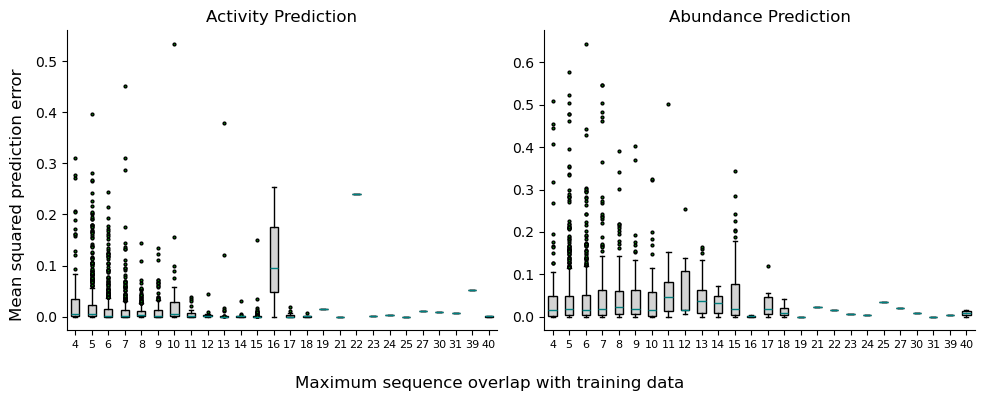

In [185]:
grouped = merged.sort_values(by=0).groupby(0)

# Prepare the boxplot for act_diff within each group
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Collect data for each group
data_to_plot = [group['act_diff'] for name, group in grouped]

flierprops = dict(marker='o', markerfacecolor='green', markersize=2, linestyle='none', markeredgecolor='black')


# Create a boxplot
bp = ax[0].boxplot(data_to_plot, patch_artist=True, flierprops=flierprops)

# Customizing whiskers, caps, and medians
for whisker in bp['whiskers']:
    whisker.set(color='black')
    
for patch in bp['boxes']:
    patch.set_facecolor('lightgrey')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='teal')


# Create a boxplot
grouped = merged.sort_values(by=0).groupby(0)

data_to_plot = [group['abund_diff'] for name, group in grouped]
bp = ax[1].boxplot(data_to_plot, patch_artist=True, flierprops=flierprops)

# Customizing whiskers, caps, and medians
for whisker in bp['whiskers']:
    whisker.set(color='black')
    
for patch in bp['boxes']:
    patch.set_facecolor('lightgrey')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='teal')


font_properties = {'size': 8}
# Setting x-tick labels with group names (optional)
ax[0].set_xticklabels([name for name, _ in grouped], fontdict=font_properties)
ax[1].set_xticklabels([name for name, _ in grouped], fontdict=font_properties)

# Adding labels and title
fig.supxlabel('Maximum sequence overlap with training data')
fig.supylabel('Mean squared prediction error')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_title("Activity Prediction")
ax[1].set_title("Abundance Prediction")

fig.tight_layout()


In [175]:
merged[merged[0] == 40]

,Sequence,0,abund_pred,abund_actual,activity_pred,activity_actual,aa_seq,abund_diff,act_diff
982,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,40,0.524900,0.510080,0.363573,0.387633,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,0.000220,0.000579
1695,LTALTSPSLFDGSPDFDTFDISPNFGHSDLENPDTWFSLF,40,0.459341,0.588346,0.985992,0.980790,LTALTSPSLFDGSPDFDTFDISPNFGHSDLENPDTWFSLF,0.016642,0.000027


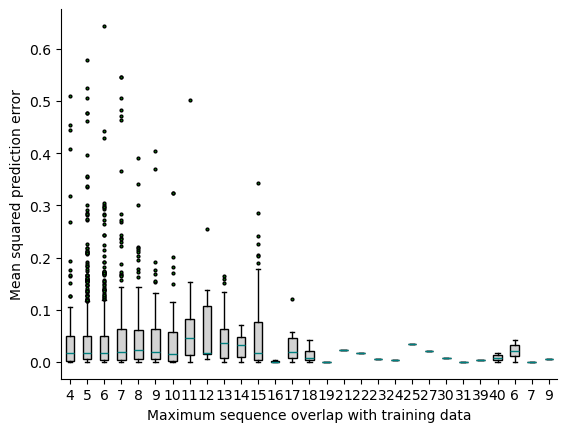

In [158]:
grouped = merged.groupby(0)

# Prepare the boxplot for act_diff within each group
fig, ax = plt.subplots()

# Collect data for each group
data_to_plot = [group['abund_diff'] for name, group in grouped]

flierprops = dict(marker='o', markerfacecolor='green', markersize=2, linestyle='none', markeredgecolor='black')


# Create a boxplot
bp = ax.boxplot(data_to_plot, patch_artist=True, flierprops=flierprops)

# for patch, color in zip(bp['boxes'], colors):
#     patch.set_facecolor(color)

# Customizing whiskers, caps, and medians
for whisker in bp['whiskers']:
    whisker.set(color='black')
    
for patch in bp['boxes']:
    patch.set_facecolor('lightgrey')

for cap in bp['caps']:
    cap.set(color='black')

for median in bp['medians']:
    median.set(color='teal')


# Setting x-tick labels with group names (optional)
ax.set_xticklabels([name for name, _ in grouped])

# Adding labels and title
ax.set_xlabel('Maximum sequence overlap with training data')
ax.set_ylabel('Mean squared prediction error')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


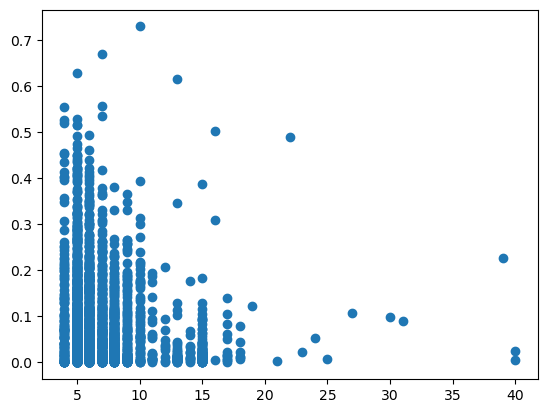

In [122]:
plt.scatter(merged[0], merged['act_diff'])